In [1]:
# Configuration Block - EDIT ONLY THIS SECTION if your columns/paths differ

CONFIG = {
    "paths": {
        "base": None,
        "files": {

            "PBCD_G": "PBCD_G.xpt",
            "PBCD_H": "PBCD_H.xpt",
            "PBCD_I": "PBCD_I.xpt",
            "PFQ_G": "PFQ_G.xpt",
            "PFQ_H": "PFQ_H.xpt",
            "PFQ_I": "PFQ_I.xpt",
            "DEMO_G": "DEMO_G.xpt",
            "DEMO_H": "DEMO_H.xpt",
            "DEMO_I": "DEMO_I.xpt",
            "BMX_G": "BMX_G.xpt",
            "BMX_H": "BMX_H.xpt",
            "BMX_I": "BMX_I.xpt",
        }
    },
    "columns": {
        "outcome": "any_disability",
        "blood_metals": {
            "lead":    "LBXBPB",  # blood lead (µg/dL)
            "cadmium": "LBXBCD",  # blood cadmium (µg/L)
            "mercury": "LBXTHG",  # blood total mercury (µg/L)
            "selenium": "LBXBSE", # blood selenium (µg/L)
            "manganese": "LBXBMN", # blood manganese (µg/L)
        },
        "covariates": {
            "age":  "RIDAGEYR",
            "sex":  "RIAGENDR",
            "race": "RIDRETH1",
            "bmi":  "BMXBMI",
        },
        "weight_2yr": "WTMEC2YR",
        "weight_6yr": "WTMEC6YR",
    },
    "outdir": "results_comprehensive",
    "seed": 42,
}





In [2]:
# Imports & Helper Functions

import os, sys, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, brier_score_loss, classification_report
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Suppress warnings
warnings.filterwarnings("ignore")
np.random.seed(CONFIG["seed"])

# Import XGBoost if available
try:
    import xgboost as xgb
    XGB_AVAILABLE = True

except ImportError:
    XGB_AVAILABLE = False


# Helper functions
def ensure_dir(path):
    """Create directory if it doesn't exist"""
    os.makedirs(path, exist_ok=True)

def log1p_safe(s: pd.Series) -> pd.Series:
    """Safe log1p transformation handling negative values"""
    s = s.astype(float)
    m = s.min(skipna=True)
    if pd.notna(m) and m < 0:
        s = s - m  # Shift to make all values non-negative
    return np.log1p(s)

def weighted_auc(y_true, y_prob, sample_weight=None):
    """Calculate weighted AUC"""
    return roc_auc_score(y_true, y_prob, sample_weight=sample_weight)

def youden_threshold(y_true, y_prob, sample_weight=None):
    """Find optimal threshold using Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob, sample_weight=sample_weight)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_sensitivity = tpr[optimal_idx]
    optimal_specificity = 1 - fpr[optimal_idx]
    return float(optimal_threshold), float(optimal_sensitivity), float(optimal_specificity)

def weighted_confusion_matrix(y_true, y_prob, threshold=0.5, sample_weight=None):
    """Calculate weighted confusion matrix metrics"""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, sample_weight=sample_weight).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan

    return {
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
        'sensitivity': sensitivity, 'specificity': specificity, 'accuracy': accuracy
    }




In [3]:
# Use existing merged_df and build comprehensive disability outcome

# Use existing merged_df

# Load and merge NHANES data files based on CONFIG
nhanes_data = {}
base_path = CONFIG["paths"]["base"] if CONFIG["paths"]["base"] else "./" # Use current directory if base is None

print("Loading NHANES data files...")
for key, filename in CONFIG["paths"]["files"].items():
    file_path = os.path.join(base_path, filename)
    if os.path.exists(file_path):
        try:
            nhanes_data[key] = pd.read_sas(file_path)
            print(f"  Loaded {filename} ({nhanes_data[key].shape[0]:,} rows)")
        except Exception as e:
            print(f"  Error loading {filename}: {e}")
    else:
        print(f"  File not found: {file_path}")

# Merge dataframes on 'SEQN' (Respondent Sequence Number)
if nhanes_data:
    # Start with the first dataframe
    first_key = list(nhanes_data.keys())[0]
    merged_df = nhanes_data[first_key].copy()
    print(f"\n Starting merge with {first_key} ({merged_df.shape})")

    # Merge the rest
    for key, df in list(nhanes_data.items())[1:]:
        if 'SEQN' in df.columns:
            initial_rows = merged_df.shape[0]
            merged_df = pd.merge(merged_df, df, on='SEQN', how='left', suffixes=('', f'_{key}'))
            print(f"  Merged {key} ({df.shape}) -> {merged_df.shape} (added {merged_df.shape[0] - initial_rows} rows, expected 0)")
        else:
            print(f"  Skipping merge for {key}: missing 'SEQN' column")

else:
    merged_df = pd.DataFrame()
    print("\n No data files loaded, merged_df is empty.")


print(f"\n Working with existing merged_df: {merged_df.shape}")
print(f" Available PFQ columns: {[col for col in merged_df.columns if col.startswith('PFQ')]}")

# Create comprehensive disability outcome using multiple PFQ items
def create_disability_outcome(df):
    """Analysis function"""
    df = df.copy()

    # PFQ items (1=Yes difficulty, 2=No difficulty, 7=Refused, 9=Don't know)
    pfq_items = {
        'PFQ049': 'Walking 1/4 mile',
        'PFQ051': 'Walking up stairs',
        'PFQ054': 'Stooping/crouching',
        'PFQ057': 'Standing up from chair',
        'PFQ059': 'Standing for periods',
    }

    available_items = {k: v for k, v in pfq_items.items() if k in df.columns}


    if not available_items:
        print("  No PFQ columns found for disability outcome creation.")
        # Check if a 'disability_status' column already exists
        if 'disability_status' in df.columns:
             print("  Using existing 'disability_status' column.")
             df[CONFIG['columns']['outcome']] = df['disability_status']
             return df
        else:
            print("  No existing 'disability_status' column found. Cannot create outcome.")
            return df # Return df without the outcome column

    # Create binary indicators for each PFQ item (1 = has difficulty)
    disability_indicators = []
    for item, description in available_items.items():
        df[f'{item}_disability'] = (df[item] == 1).astype(int)
        disability_indicators.append(f'{item}_disability')
        print(f"   {item}: {description} - {df[f'{item}_disability'].sum():,} with difficulty")

    # Create comprehensive disability outcome
    # Person has disability if they report difficulty with ANY of the activities
    df[CONFIG['columns']['outcome']] = (df[disability_indicators].sum(axis=1) >= 1).astype(int)

    return df

# Apply disability outcome creation
work_df = create_disability_outcome(merged_df)

# Display outcome distribution
outcome_col = CONFIG['columns']['outcome']
if outcome_col in work_df.columns:
    outcome_dist = work_df[outcome_col].value_counts()
    outcome_pct = work_df[outcome_col].value_counts(normalize=True) * 100

    print(f"\n {outcome_col} Distribution:")
    print(f"   No disability (0): {outcome_dist.get(0, 0):,} ({outcome_pct.get(0, 0):.1f}%)")
    print(f"   Has disability (1): {outcome_dist.get(1, 0):,} ({outcome_pct.get(1, 0):.1f}%)")
else:
    print(f"  Outcome column '{outcome_col}' not created. Check data loading and PFQ columns.")
    # This case should ideally not happen if PFQ data is loaded correctly, but as a fallback:
    # If no PFQ data and no existing 'disability_status', the outcome won't exist.
    pass # No action needed, the message above indicates the issue.

Loading NHANES data files...
  Loaded PBCD_G.xpt (8,956 rows)
  Loaded PBCD_H.xpt (5,932 rows)
  Loaded PBCD_I.xpt (5,815 rows)
  Loaded PFQ_G.xpt (8,350 rows)
  Loaded PFQ_H.xpt (9,230 rows)
  Loaded PFQ_I.xpt (8,991 rows)
  Loaded DEMO_G.xpt (9,756 rows)
  Loaded DEMO_H.xpt (10,175 rows)
  Loaded DEMO_I.xpt (9,971 rows)
  Loaded BMX_G.xpt (9,338 rows)
  Loaded BMX_H.xpt (9,813 rows)
  Loaded BMX_I.xpt (9,544 rows)

 Starting merge with PBCD_G ((8956, 16))
  Merged PBCD_H ((5932, 17)) -> (8956, 32) (added 0 rows, expected 0)
  Merged PBCD_I ((5815, 17)) -> (8956, 48) (added 0 rows, expected 0)
  Merged PFQ_G ((8350, 35)) -> (8956, 82) (added 0 rows, expected 0)
  Merged PFQ_H ((9230, 36)) -> (8956, 117) (added 0 rows, expected 0)
  Merged PFQ_I ((8991, 36)) -> (8956, 152) (added 0 rows, expected 0)
  Merged DEMO_G ((9756, 48)) -> (8956, 199) (added 0 rows, expected 0)
  Merged DEMO_H ((10175, 47)) -> (8956, 245) (added 0 rows, expected 0)
  Merged DEMO_I ((9971, 47)) -> (8956, 291) (a

In [4]:
# Feature Engineering: Metals log transforms, quartiles, covariates, and weights

C = CONFIG["columns"]
outcome_col = C["outcome"]

# Get blood metal columns that exist in our data
blood_metals = list(C["blood_metals"].values())
metal_cols = [col for col in blood_metals if col in work_df.columns]
covar_cols = [col for col in C["covariates"].values() if col in work_df.columns]

print(f" Available metal columns: {metal_cols}")
print(f" Available covariate columns: {covar_cols}")

# Filter to valid outcome cases and ensure we have the outcome
work_df = work_df[work_df[outcome_col].isin([0, 1])].copy()
work_df = work_df.dropna(subset=[outcome_col])

print(f" Working dataset after filtering: {work_df.shape}")

# Winsorize metals at 99th percentile and apply log1p transformation
print(f"\n Processing metal concentrations:")
for metal in metal_cols:
    if metal in work_df.columns:
        # Winsorize at 99th percentile
        q99 = work_df[metal].quantile(0.99)
        work_df[metal] = np.where(work_df[metal] > q99, q99, work_df[metal])

        # Apply safe log1p transformation
        work_df[f"log_{metal}"] = log1p_safe(work_df[metal])

        print(f"   {metal}: winsorized at {q99:.3f}, log-transformed")

# Create quartiles for each metal (for descriptive analysis)
print(f"\n Creating metal quartiles:")
for metal in metal_cols:
    if metal in work_df.columns:
        try:
            work_df[f"q_{metal}"] = pd.qcut(
                work_df[metal].rank(method="first"),
                4,
                labels=[1, 2, 3, 4]
            ).astype(float)

        except Exception as e:
            work_df[f"q_{metal}"] = np.nan
            print(f"   {metal}: quartile creation failed - {e}")

# Handle survey weights - create 6-year MEC weight
w2_col, w6_col = C["weight_2yr"], C["weight_6yr"]

if w2_col in work_df.columns:
    if w6_col not in work_df.columns:
        work_df[w6_col] = work_df[w2_col] / 3.0
        print(f" Created 6-year MEC weights: {w6_col}")

    # Choose weight series (prefer 6-year)
    weight_col = w6_col if w6_col in work_df.columns else w2_col
    weights = work_df[weight_col].copy()

    # Handle any negative or zero weights
    weights = weights.fillna(weights.median())
    weights = np.where(weights <= 0, weights[weights > 0].min(), weights)

    print(f"📏 Using weights: {weight_col}")
    print(f"   Weight range: {weights.min():.1f} to {weights.max():.1f}")
    print(f"   Mean weight: {weights.mean():.1f}")
else:
    weights = None
    weight_col = None


# Add BMI from BMX files if not already present
if 'BMXBMI' not in work_df.columns and 'BMX_G' in nhanes_data:
    print(" Adding BMI data from BMX files...")

    # Combine BMI data from all cycles
    bmx_frames = []
    for cycle in ['G', 'H', 'I']:
        if f'BMX_{cycle}' in nhanes_data:
            bmx_data = nhanes_data[f'BMX_{cycle}'][['SEQN', 'BMXBMI']].copy()
            bmx_frames.append(bmx_data)

    if bmx_frames:
        bmx_combined = pd.concat(bmx_frames, ignore_index=True)
        bmx_combined = bmx_combined.drop_duplicates(subset=['SEQN'], keep='first')

        # Merge with work_df
        work_df = work_df.merge(bmx_combined, on='SEQN', how='left')
        print(f" BMI data added: {work_df['BMXBMI'].notna().sum():,} valid BMI values")

# Final feature preparation
log_metals = [f"log_{metal}" for metal in metal_cols if f"log_{metal}" in work_df.columns]
num_covars = [col for col in [C["covariates"]["age"], C["covariates"]["bmi"]]
              if col and col in work_df.columns]
cat_covars = [col for col in [C["covariates"]["sex"], C["covariates"]["race"]]
              if col and col in work_df.columns and work_df[col].dtype.kind not in "biufc"]

# Combine all features
feature_cols = log_metals + num_covars + cat_covars
feature_cols = [col for col in feature_cols if col in work_df.columns]

print(f"\n Final feature set ({len(feature_cols)} features):")
print(f"   Log-transformed metals: {log_metals}")
print(f"   Numerical covariates: {num_covars}")
print(f"   Categorical covariates: {cat_covars}")

# Summary statistics
print(f"\n Dataset summary:")
print(f"   Total observations: {len(work_df):,}")
print(f"   Disability cases: {work_df[outcome_col].sum():,} ({work_df[outcome_col].mean()*100:.1f}%)")
print(f"   Complete cases (all features): {work_df[feature_cols + [outcome_col]].dropna().shape[0]:,}")




 Available metal columns: ['LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN']
 Available covariate columns: ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']
 Working dataset after filtering: (8956, 372)

 Processing metal concentrations:
   LBXBPB: winsorized at 6.865, log-transformed
   LBXBCD: winsorized at 2.680, log-transformed
   LBXTHG: winsorized at 10.421, log-transformed
   LBXBSE: winsorized at 259.049, log-transformed
   LBXBMN: winsorized at 23.283, log-transformed

 Creating metal quartiles:
 Created 6-year MEC weights: WTMEC6YR
📏 Using weights: WTMEC6YR
   Weight range: 1257.6 to 74193.3
   Mean weight: 11273.8

 Final feature set (7 features):
   Log-transformed metals: ['log_LBXBPB', 'log_LBXBCD', 'log_LBXTHG', 'log_LBXBSE', 'log_LBXBMN']
   Numerical covariates: ['RIDAGEYR', 'BMXBMI']
   Categorical covariates: []

 Dataset summary:
   Total observations: 8,956
   Disability cases: 1,439 (16.1%)
   Complete cases (all features): 7,701


In [5]:
# Train/Test Split & Preprocessing Pipeline

# Prepare modeling dataset
modeling_df = work_df.dropna(subset=feature_cols + [outcome_col]).copy()
print(f" Modeling dataset: {modeling_df.shape}")

# Extract features and target
X = modeling_df[feature_cols].copy()
y = modeling_df[outcome_col].astype(int).values

# Extract weights for modeling subset
if weights is not None:
    w = modeling_df[weight_col].values
    w = np.where(w <= 0, np.median(w[w > 0]), w)  # Handle any remaining zero/negative weights
else:
    w = None

print(f" Features: {X.shape}")
print(f" Target distribution: {np.bincount(y)} (class 0/1)")
if w is not None:
    print(f"  Weights: {len(w)} values, range {w.min():.1f}-{w.max():.1f}")

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=CONFIG["seed"], stratify=y
)

# Split weights accordingly
if w is not None:
    w_train, w_test = train_test_split(
        w, test_size=0.25, random_state=CONFIG["seed"], stratify=y
    )
else:
    w_train, w_test = None, None

print(f" Training set: {X_train.shape}")
print(f" Test set: {X_test.shape}")
print(f"   Train target distribution: {np.bincount(y_train)}")
print(f"   Test target distribution: {np.bincount(y_test)}")

# Create preprocessing pipeline
# Separate numerical and categorical columns
num_cols = [col for col in feature_cols if col in log_metals + num_covars]
cat_cols = [col for col in feature_cols if col in cat_covars]

print(f" Numerical features: {num_cols}")
print(f"  Categorical features: {cat_cols}")

# Build preprocessor
transformers = []
if num_cols:
    transformers.append(("num", "passthrough", num_cols))
if cat_cols:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop"
)

# Fit preprocessor on training data
preprocessor.fit(X_train)

# Get feature names after preprocessing
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f" Final feature names after preprocessing: {len(feature_names)} features")
except:
    feature_names = None
    print("  Could not extract feature names from preprocessor")

print(" Train/test split and preprocessing pipeline ready")


 Modeling dataset: (7701, 383)
 Features: (7701, 7)
 Target distribution: [6402 1299] (class 0/1)
  Weights: 7701 values, range 1274.0-74193.3
 Training set: (5775, 7)
 Test set: (1926, 7)
   Train target distribution: [4801  974]
   Test target distribution: [1601  325]
 Numerical features: ['log_LBXBPB', 'log_LBXBCD', 'log_LBXTHG', 'log_LBXBSE', 'log_LBXBMN', 'RIDAGEYR', 'BMXBMI']
  Categorical features: []
 Final feature names after preprocessing: 7 features
 Train/test split and preprocessing pipeline ready


In [6]:
# Build and Train Model: XGBoost or GradientBoosting Only

print(" Building and training models...")

# Model: XGBoost or Gradient Boosting
if XGB_AVAILABLE:
    print("\n Training XGBoost...")
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier(
            n_estimators=800,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            learning_rate=0.03,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="auc",
            n_jobs=-1,
            random_state=CONFIG["seed"],
            tree_method="hist"
        ))
    ])
    model_name = "XGBoost"
else:
    print("\n Training Gradient Boosting...")
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=3,
            random_state=CONFIG["seed"]
        ))
    ])
    model_name = "GradientBoosting"

xgb_pipeline.fit(X_train, y_train, classifier__sample_weight=w_train)

# Generate predictions on test set
print("\n Generating predictions...")
models = {
    model_name: xgb_pipeline
}

predictions = {}
for name, model in models.items():
    pred_proba = model.predict_proba(X_test)[:, 1]
    predictions[name] = pred_proba


 Building and training models...

 Training XGBoost...

 Generating predictions...


In [7]:
# Comprehensive Model Evaluation for XGBoost/GradientBoosting Only

# Calculate metrics for XGBoost model
performance_results = []

model_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"
y_pred_proba = predictions[model_name]

print(f"\n Evaluating {model_name}...")

# Basic metrics
auc_score = weighted_auc(y_test, y_pred_proba, sample_weight=w_test)
ap_score = average_precision_score(y_test, y_pred_proba, sample_weight=w_test)

# Optimal threshold using Youden's J statistic
opt_threshold, sensitivity, specificity = youden_threshold(y_test, y_pred_proba, sample_weight=w_test)

# Confusion matrix metrics at optimal threshold
cm_metrics = weighted_confusion_matrix(y_test, y_pred_proba, opt_threshold, sample_weight=w_test)

# Brier score (lower is better)
brier = brier_score_loss(y_test, y_pred_proba, sample_weight=w_test)

# Store results
result = {
    'Model': model_name,
    'AUC': round(auc_score, 4),
    'PR_AUC': round(ap_score, 4),
    'Brier_Score': round(brier, 4),
    'Optimal_Threshold': round(opt_threshold, 4),
    'Sensitivity': round(sensitivity, 4),
    'Specificity': round(specificity, 4),
    'Accuracy': round(cm_metrics['accuracy'], 4),
    'TP': int(cm_metrics['tp']),
    'FP': int(cm_metrics['fp']),
    'TN': int(cm_metrics['tn']),
    'FN': int(cm_metrics['fn'])
}

performance_results.append(result)

print(f"   AUC: {auc_score:.4f}")
print(f"   PR-AUC: {ap_score:.4f}")
print(f"   Brier Score: {brier:.4f}")
print(f"   Optimal Threshold: {opt_threshold:.4f}")
print(f"   Sensitivity: {sensitivity:.4f}")
print(f"   Specificity: {specificity:.4f}")

# Create performance DataFrame
performance_df = pd.DataFrame(performance_results)
performance_df = performance_df.sort_values('AUC', ascending=False).reset_index(drop=True)

print(f"\n Model Performance Summary:")
print("=" * 80)
display(performance_df[['Model', 'AUC', 'PR_AUC', 'Brier_Score', 'Sensitivity', 'Specificity', 'Accuracy']])

# Identify best model
best_model_name = performance_df.iloc[0]['Model']
best_auc = performance_df.iloc[0]['AUC']
print(f"\n Best performing model: {best_model_name} (AUC: {best_auc:.4f})")



 Evaluating XGBoost...
   AUC: 0.7412
   PR-AUC: 0.3666
   Brier Score: 0.1419
   Optimal Threshold: 0.1439
   Sensitivity: 0.7300
   Specificity: 0.6598

 Model Performance Summary:


Model     AUC  PR_AUC  Brier_Score  Sensitivity  Specificity  Accuracy
0  XGBoost  0.7412  0.3666       0.1419         0.73       0.6598    0.6726


 Best performing model: XGBoost (AUC: 0.7412)


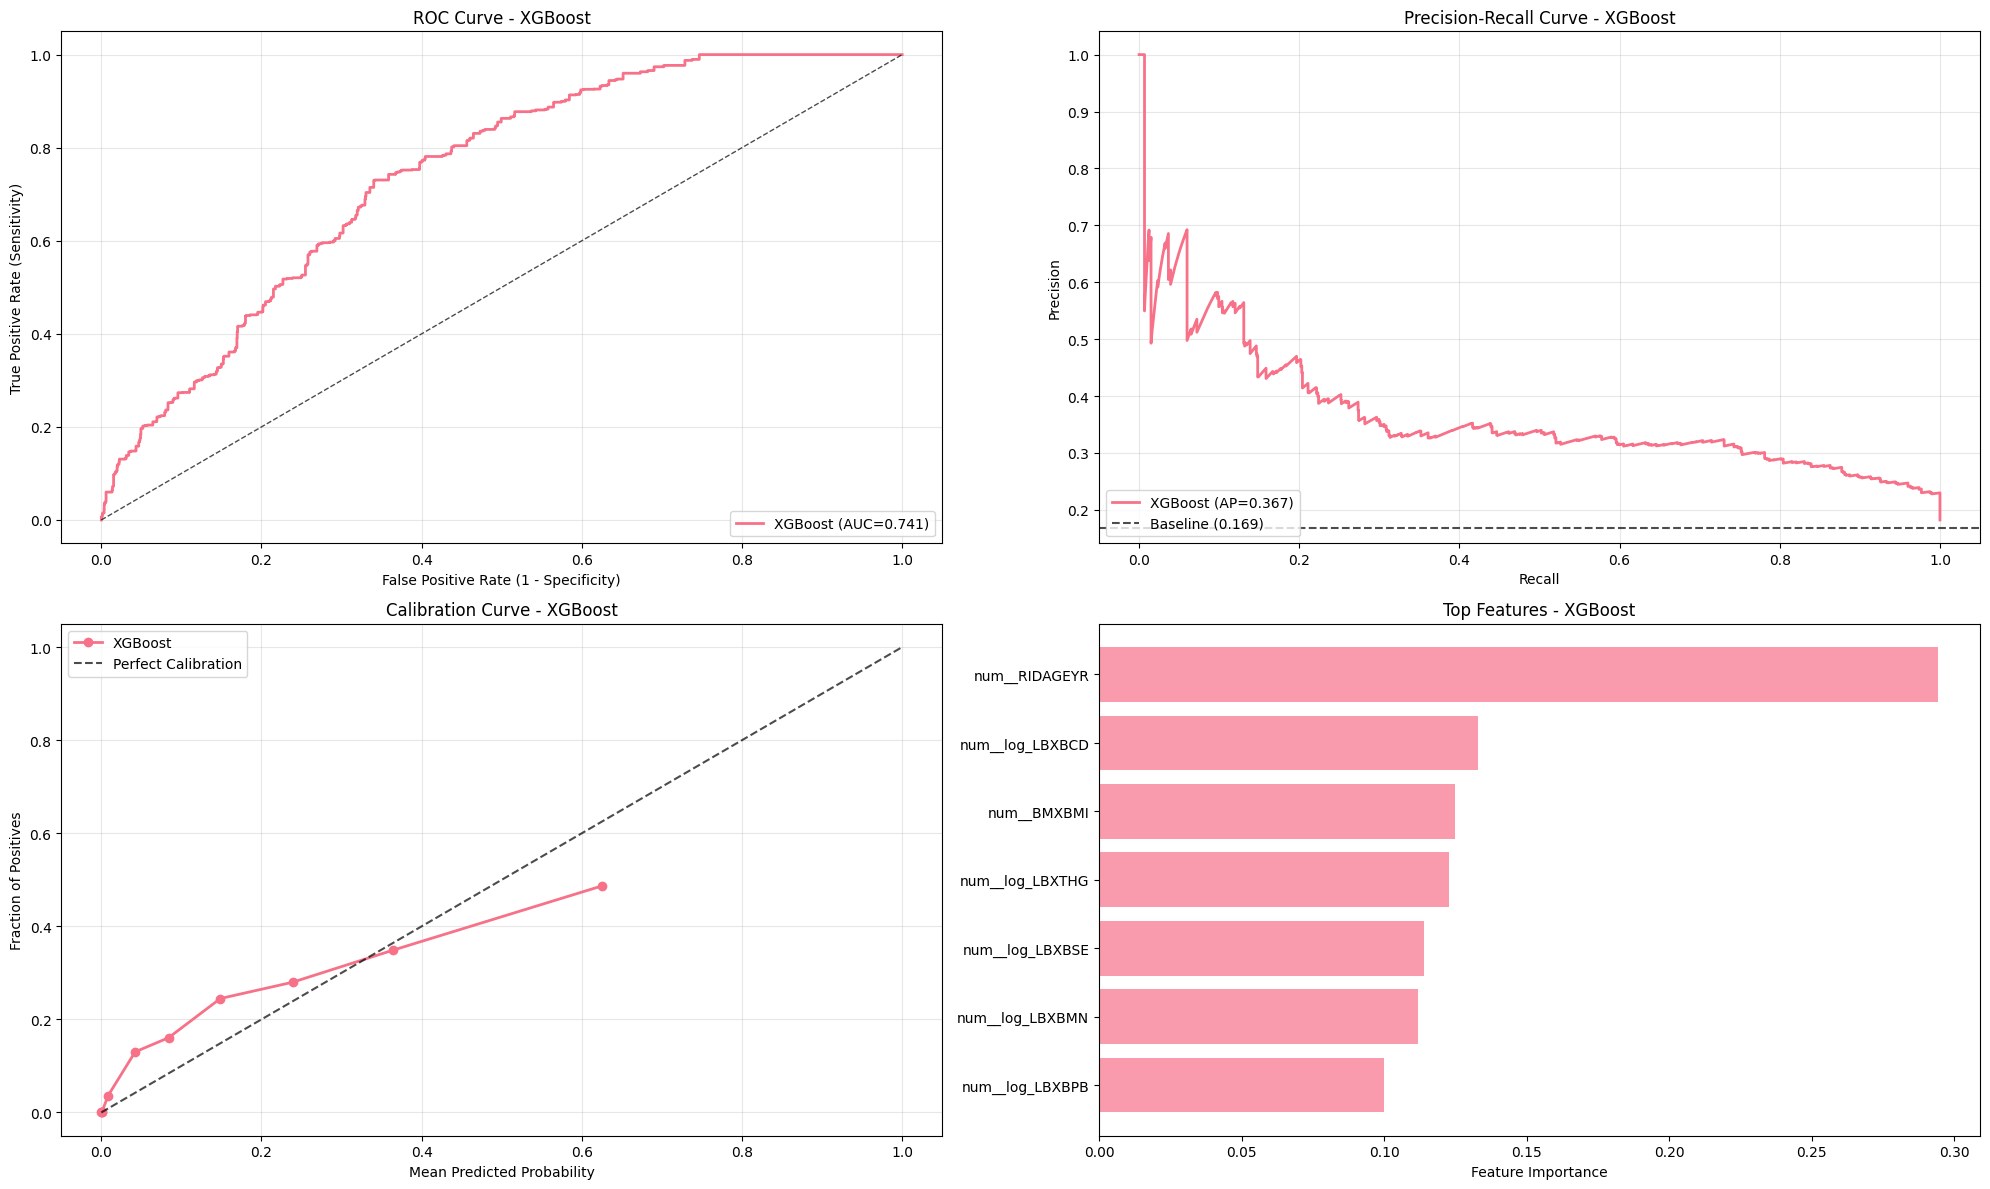

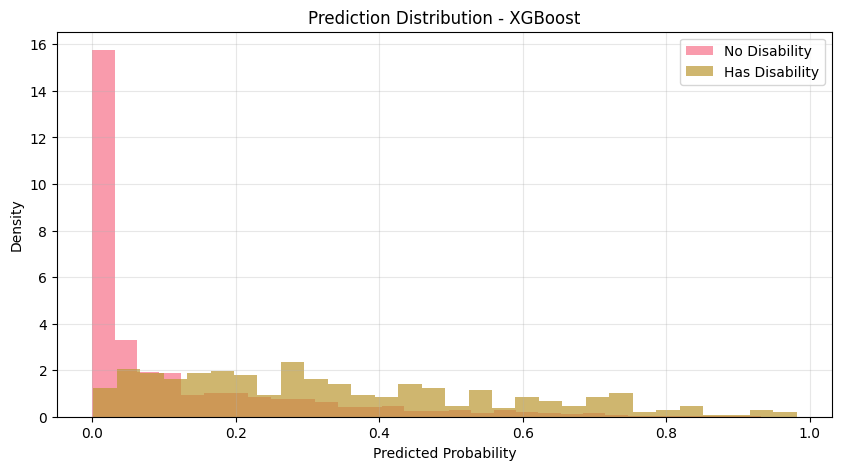

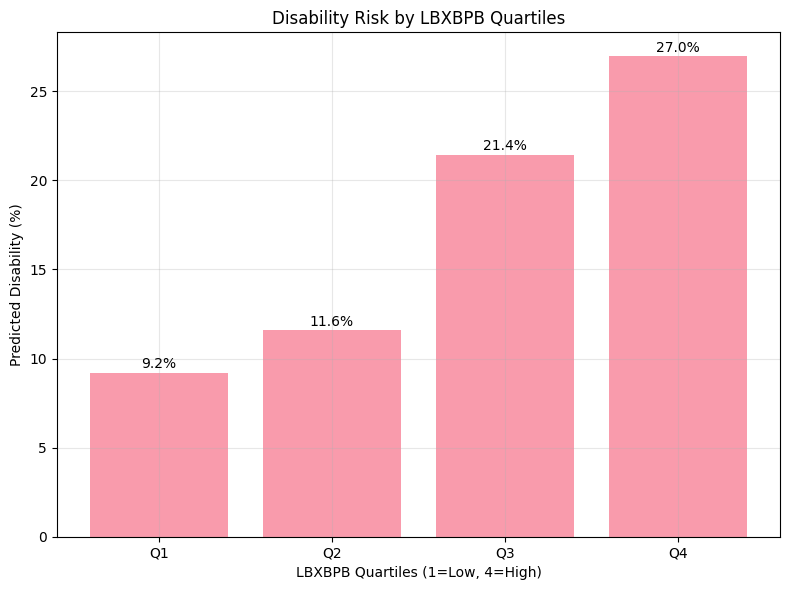

In [8]:
# Comprehensive Visualizations for XGBoost Only

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Determine model name
model_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"
y_pred_proba = predictions[model_name]
best_pred = y_pred_proba  # also used later

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# ROC Curve
ax1 = plt.subplot(2, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, sample_weight=w_test)
auc_score = weighted_auc(y_test, y_pred_proba, sample_weight=w_test)
plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title(f'ROC Curve - {model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = plt.subplot(2, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, sample_weight=w_test)
ap_score = average_precision_score(y_test, y_pred_proba, sample_weight=w_test)
plt.plot(recall, precision, linewidth=2, label=f'{model_name} (AP={ap_score:.3f})')

baseline = np.sum(y_test) / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.7, label=f'Baseline ({baseline:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {model_name}')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Calibration Curve
ax3 = plt.subplot(2, 2, 3)
cal_model_name = f"{model_name}_Cal"
if cal_model_name in predictions:
    cal_proba = predictions[cal_model_name]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, cal_proba, n_bins=10, strategy='quantile'
    )
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2,
             label=cal_model_name)
else:
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=10, strategy='quantile'
    )
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2,
             label=model_name)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve - {model_name}')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature Importance
ax4 = plt.subplot(2, 2, 4)
try:
    xgb_classifier = models[model_name].named_steps['classifier']
    if hasattr(xgb_classifier, 'feature_importances_') and feature_names is not None:
        importances = xgb_classifier.feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)

        plt.barh(range(len(feature_imp_df)), feature_imp_df['importance'], alpha=0.7)
        plt.yticks(range(len(feature_imp_df)), feature_imp_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top Features - {model_name}')
        plt.gca().invert_yaxis()
    else:
        plt.text(0.5, 0.5, 'Feature importances not available',
                 ha='center', va='center', transform=plt.gca().transAxes)
except Exception as e:
    plt.text(0.5, 0.5, f'Error extracting importances:\n{str(e)[:50]}...',
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Additional: Prediction Distribution
plt.figure(figsize=(10, 5))
plt.hist(best_pred[y_test == 0], bins=30, alpha=0.7, label='No Disability', density=True)
plt.hist(best_pred[y_test == 1], bins=30, alpha=0.7, label='Has Disability', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title(f'Prediction Distribution - {model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Quartile Analysis
if metal_cols:
    plt.figure(figsize=(8, 6))
    metal_for_plot = metal_cols[0]
    quartile_col = f"q_{metal_for_plot}"

    if quartile_col in modeling_df.columns:
        test_indices = X_test.index
        test_quartiles = modeling_df.loc[test_indices, quartile_col]
        quartile_probs = []
        quartile_labels = []

        for q in [1, 2, 3, 4]:
            mask = test_quartiles == q
            if mask.sum() > 0:
                if w_test is not None:
                    mean_prob = np.average(best_pred[mask], weights=w_test[mask])
                else:
                    mean_prob = np.mean(best_pred[mask])
                quartile_probs.append(mean_prob * 100)
                quartile_labels.append(f'Q{int(q)}')

        if quartile_probs:
            bars = plt.bar(quartile_labels, quartile_probs, alpha=0.7)
            plt.xlabel(f'{metal_for_plot} Quartiles (1=Low, 4=High)')
            plt.ylabel('Predicted Disability (%)')
            plt.title(f'Disability Risk by {metal_for_plot} Quartiles')
            plt.grid(True, alpha=0.3)

            for bar, prob in zip(bars, quartile_probs):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                         f'{prob:.1f}%', ha='center', va='bottom')
        else:
            plt.text(0.5, 0.5, 'No valid quartile data',
                     ha='center', va='center', transform=plt.gca().transAxes)
    else:
        plt.text(0.5, 0.5, f'Quartile column {quartile_col} not found',
                 ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()
else:
    print("No metal columns available for quartile analysis.")



 XGBoost - Feature Importance:
Top 15 features by importance:


Feature  Importance
5    num__RIDAGEYR    0.294235
1  num__log_LBXBCD    0.132827
6      num__BMXBMI    0.124737
2  num__log_LBXTHG    0.122598
3  num__log_LBXBSE    0.113918
4  num__log_LBXBMN    0.111881
0  num__log_LBXBPB    0.099803

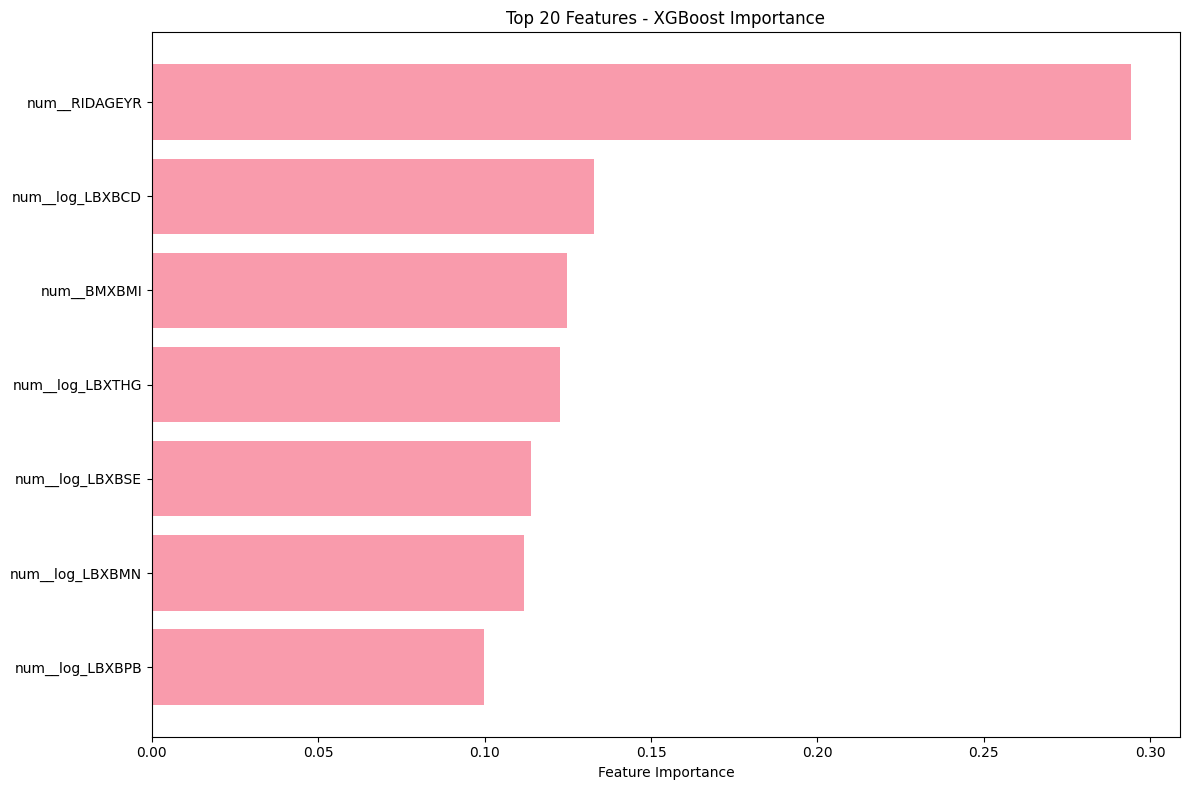

In [9]:
# Detailed Feature Importance Analysis for XGBoost Only

print(f"\n {model_name} - Feature Importance:")

try:
    xgb_classifier = xgb_pipeline.named_steps['classifier']
    if hasattr(xgb_classifier, 'feature_importances_') and feature_names is not None:
        xgb_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': xgb_classifier.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("Top 15 features by importance:")
        display(xgb_importance_df.head(15))

        # Create importance plot
        plt.figure(figsize=(12, 8))
        top_xgb_features = xgb_importance_df.head(20)

        plt.barh(range(len(top_xgb_features)), top_xgb_features['Importance'], alpha=0.7)
        plt.yticks(range(len(top_xgb_features)), top_xgb_features['Feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 20 Features - {model_name} Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    else:
        print("  Feature names not available or classifier lacks feature_importances_")

except Exception as e:
    print(f"  Error in {model_name} analysis: {e}")


In [11]:
# Export All Results to CSV Files (XGBoost Only)

# Create output directory
ensure_dir(CONFIG["outdir"])
print(f" Output directory: {CONFIG['outdir']}")

# Export model performance summary
performance_file = os.path.join(CONFIG["outdir"], "xgboost_model_performance.csv")
performance_df.to_csv(performance_file, index=False)

# --- Export ROC curve data for XGBoost ---
best_pred = predictions["XGBoost" if XGB_AVAILABLE else "GradientBoosting"]
fpr, tpr, thresholds = roc_curve(y_test, best_pred, sample_weight=w_test)
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})
roc_file = os.path.join(CONFIG["outdir"], f"roc_curve_{model_name.lower()}.csv")
roc_df.to_csv(roc_file, index=False)

# --- Export Precision‑Recall curve data ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, best_pred, sample_weight=w_test)
pr_df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'threshold': np.append(pr_thresholds, 1)
})
pr_file = os.path.join(CONFIG["outdir"], f"precision_recall_{model_name.lower()}.csv")
pr_df.to_csv(pr_file, index=False)

# --- Export calibration data ---
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, best_pred, n_bins=10, strategy='quantile'
)
cal_df = pd.DataFrame({
    'bin_number': range(1, 11),
    'mean_predicted_probability': mean_predicted_value,
    'observed_fraction': fraction_of_positives
})
cal_file = os.path.join(CONFIG["outdir"], f"calibration_data_{model_name.lower()}.csv")
cal_df.to_csv(cal_file, index=False)

# --- Export feature importance data (XGBoost only) ---
if feature_names is not None:
    try:
        xgb_classifier = xgb_pipeline.named_steps['classifier']
        if hasattr(xgb_classifier, 'feature_importances_'):
            xgb_imp_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': xgb_classifier.feature_importances_
            }).sort_values('Importance', ascending=False)

            xgb_file = os.path.join(CONFIG["outdir"], f"{model_name.lower()}_feature_importance.csv")
            xgb_imp_df.to_csv(xgb_file, index=False)
            print(f"  Saved {model_name} feature importances to: {xgb_file}")
    except Exception as e:
        print(f"  Could not save {model_name} importance: {e}")

# --- Export predictions for XGBoost ---
pred_df = pd.DataFrame({
    'y_true': y_test,
    f'{model_name}_Predicted_Prob': best_pred
})
if w_test is not None:
    pred_df['sample_weight'] = w_test

pred_file = os.path.join(CONFIG["outdir"], f"{model_name.lower()}_predictions.csv")
pred_df.to_csv(pred_file, index=False)

# --- Export quartile analysis ---
if metal_cols:
    metal_for_export = metal_cols[0]
    quartile_col = f"q_{metal_for_export}"
    if quartile_col in modeling_df.columns:
        try:
            test_indices = X_test.index
            quartile_analysis = []

            for q in [1, 2, 3, 4]:
                mask = modeling_df.loc[test_indices, quartile_col] == q
                if mask.sum() > 0:
                    test_mask_array = mask.values
                    if w_test is not None:
                        mean_prob = np.average(best_pred[test_mask_array], weights=w_test[test_mask_array])
                        weighted_count = w_test[test_mask_array].sum()
                    else:
                        mean_prob = np.mean(best_pred[test_mask_array])
                        weighted_count = test_mask_array.sum()

                    quartile_analysis.append({
                        'Metal': metal_for_export,
                        'Quartile': int(q),
                        'N_Observations': test_mask_array.sum(),
                        'Weighted_N': weighted_count if w_test is not None else test_mask_array.sum(),
                        'Mean_Predicted_Probability': mean_prob,
                        'Mean_Predicted_Percentage': mean_prob * 100
                    })

            if quartile_analysis:
                quartile_df = pd.DataFrame(quartile_analysis)
                quartile_file = os.path.join(CONFIG["outdir"], f"quartile_analysis_{metal_for_export}.csv")
                quartile_df.to_csv(quartile_file, index=False)
                print(f"  Saved quartile analysis to: {quartile_file}")

        except Exception as e:
            print(f"  Could not save quartile analysis: {e}")

# --- Export summary statistics ---
summary_stats = {
    'Analysis_Date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Total_Observations': len(work_df),
    'Modeling_Observations': len(modeling_df),
    'Training_Observations': len(X_train),
    'Test_Observations': len(X_test),
    'Outcome_Variable': outcome_col,
    'Disability_Cases_Total': work_df[outcome_col].sum(),
    'Disability_Rate_Percent': work_df[outcome_col].mean() * 100,
    'Model_Name': model_name,
    'Model_AUC': best_auc,
    'Number_Features': len(feature_cols),
    'Metal_Features': len([col for col in feature_cols if 'log_' in col]),
    'Demographic_Features': len([col for col in feature_cols if col in covar_cols]),
    'Survey_Weights_Used': weight_col if weight_col else 'None'
}

summary_df = pd.DataFrame([summary_stats])
summary_file = os.path.join(CONFIG["outdir"], f"{model_name.lower()}_summary.csv")
summary_df.to_csv(summary_file, index=False)

# --- Create README for this XGBoost run ---
readme_content = f"""# NHANES Heavy Metals & Disability Analysis — {model_name} Results

## Overview
- **Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Dataset**: NHANES 2011–2016 (Cycles G, H, I)
- **Outcome**: {CONFIG['columns']['outcome']}
- **Model Used**: {model_name}
- **AUC**: {best_auc:.4f}
- **Training Samples**: {len(X_train):,}
- **Test Samples**: {len(X_test):,}
- **Survey Weights**: {'Applied' if weight_col else 'Not Applied'}

## Exported Files
- `{model_name.lower()}_feature_importance.csv` — feature importances
- `{model_name.lower()}_predictions.csv` — predicted probabilities
- `roc_curve_{model_name.lower()}.csv` — ROC data
- `precision_recall_{model_name.lower()}.csv` — PR curve data
- `calibration_data_{model_name.lower()}.csv` — calibration data
- `quartile_analysis_{metal_cols[0] if metal_cols else 'metal'}.csv` — exposure quartile analysis
- `{model_name.lower()}_summary.csv` — key statistics summary
"""

readme_file = os.path.join(CONFIG["outdir"], f"README_{model_name.lower()}.md")
with open(readme_file, "w") as f:
    f.write(readme_content)

print(f"All XGBoost results successfully exported to {CONFIG['outdir']}")


 Output directory: results_comprehensive
  Saved XGBoost feature importances to: results_comprehensive/xgboost_feature_importance.csv
  Saved quartile analysis to: results_comprehensive/quartile_analysis_LBXBPB.csv
All XGBoost results successfully exported to results_comprehensive
